## Team Payroll Efficiency Analysis (2000–2016)

This notebook explores how efficiently MLB teams convert payroll into on-field performance.
Using a team-season dataset combining payroll, wins, and WAR, we analyze:

- The relationship between spending, WAR, and wins
- Variation in efficiency across teams and seasons
- Which organizations consistently outperform their financial constraints

All data preparation is completed in Notebook 01.


## Load dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/team_wins_payroll_war_efficiency_2000_2016.csv")

print(df.shape)
df.head()

(510, 12)


,yearID,teamID,name,W,payroll,Batting_WAR,Pitching_WAR,Total_WAR,Dollars_per_Win,Dollars_per_WAR,WAR_per_Million,Wins_per_100M
0,2000,ANA,Anaheim Angels,82,51464167,30.250,8.410000,38.660000,6.276118e+05,1.331199e+06,0.751202,159.334164
1,2000,ARI,Arizona Diamondbacks,85,81027833,13.965,20.973333,34.938333,9.532686e+05,2.319167e+06,0.431189,104.902225
2,2000,ATL,Atlanta Braves,95,84537836,24.530,21.163333,45.693333,8.898720e+05,1.850113e+06,0.540507,112.375718
3,2000,BAL,Baltimore Orioles,74,81447435,17.065,8.560000,25.625000,1.100641e+06,3.178436e+06,0.314620,90.856145
4,2000,BOS,Boston Red Sox,85,77940333,15.940,24.290000,40.230000,9.169451e+05,1.937368e+06,0.516164,109.057784


In [5]:
df.isna().sum().sort_values(ascending=False).head(10)
df[["W", "payroll", "Total_WAR", "Batting_WAR", "Pitching_WAR"]].describe()

,W,payroll,Total_WAR,Batting_WAR,Pitching_WAR
count,510.000000,5.100000e+02,510.000000,510.000000,510.000000
mean,80.964706,8.650195e+07,33.439137,19.329698,14.109439
std,11.365111,3.992242e+07,10.850965,7.451069,6.009201
min,43.000000,1.467150e+07,1.088333,-0.510000,-2.316667
25%,72.000000,5.907392e+07,25.208333,14.506250,9.614488
50%,82.000000,8.041048e+07,34.031667,19.175000,14.395000
75%,90.000000,1.040865e+08,41.587927,24.148144,18.505000
max,116.000000,2.319789e+08,69.028333,47.425000,33.516667


## Big Picture Relationships

Payroll vs Wins

<function matplotlib.pyplot.show(close=None, block=None)>

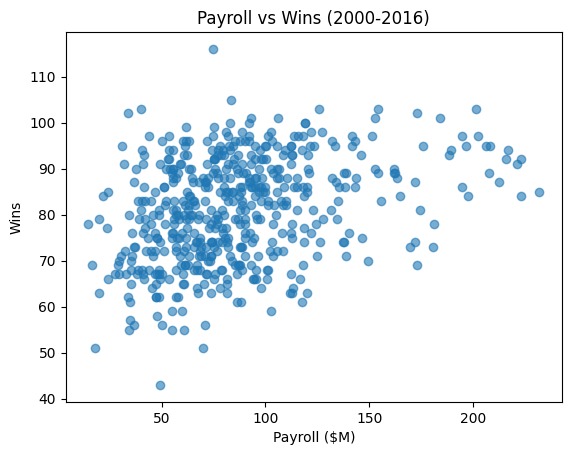

In [6]:
plt.figure()
plt.scatter(df["payroll"]/1e6, df["W"], alpha=0.6)
plt.xlabel("Payroll ($M)")
plt.ylabel("Wins")
plt.title("Payroll vs Wins (2000-2016)")
plt.show

In [7]:
df[["W", "payroll", "Total_WAR"]].corr()

,W,payroll,Total_WAR
W,1.000000,0.342266,0.921338
payroll,0.342266,1.000000,0.334778
Total_WAR,0.921338,0.334778,1.000000


WAR vs Wins

<function matplotlib.pyplot.show(close=None, block=None)>

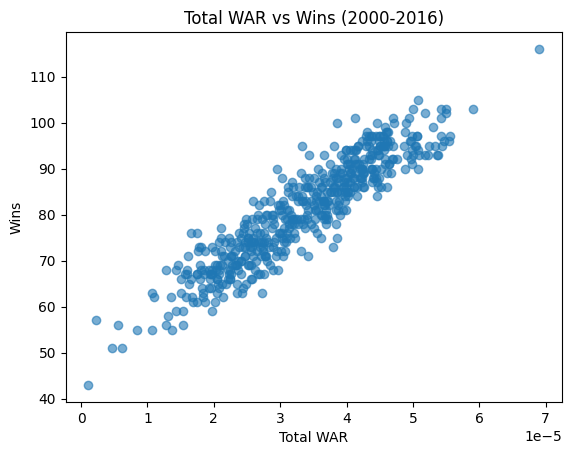

In [8]:
plt.figure()
plt.scatter(df["Total_WAR"]/1e6, df["W"], alpha=0.6)
plt.xlabel("Total WAR")
plt.ylabel("Wins")
plt.title("Total WAR vs Wins (2000-2016)")
plt.show

Payroll vs WAR

<function matplotlib.pyplot.show(close=None, block=None)>

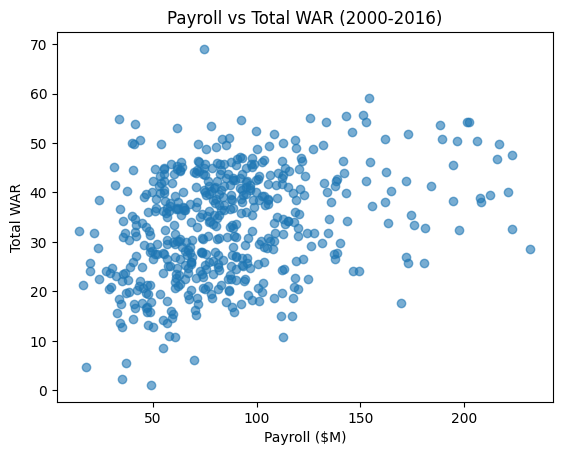

In [9]:
plt.figure()
plt.scatter(df["payroll"]/1e6, df["Total_WAR"], alpha=0.6)
plt.xlabel("Payroll ($M)")
plt.ylabel("Total WAR")
plt.title("Payroll vs Total WAR (2000-2016)")
plt.show

## Efficieny Metrics

In [10]:
df = df.copy()
df["Dollars_per_Win"] = df["payroll"] / df["W"]
df["Dollars_per_WAR"] = df["payroll"] / df["Total_WAR"]
df["WAR_per_Million"] = df["Total_WAR"] / (df["payroll"]/1000000)

## Dollars per WAR

<function matplotlib.pyplot.show(close=None, block=None)>

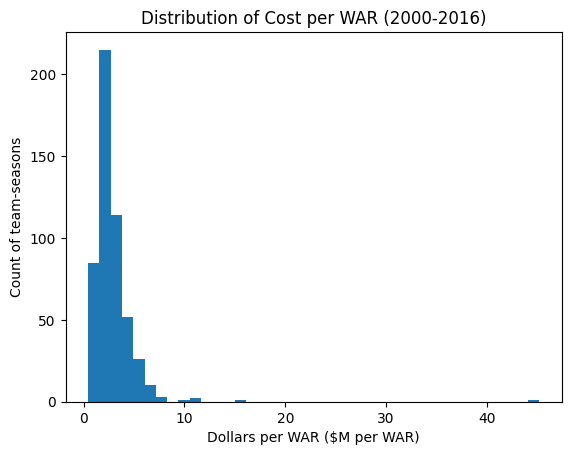

In [11]:
clean = df[df["Total_WAR"] > 0].copy()

plt.figure()
plt.hist(clean["Dollars_per_WAR"]/1e6, bins = 40)
plt.xlabel("Dollars per WAR ($M per WAR)")
plt.ylabel("Count of team-seasons")
plt.title("Distribution of Cost per WAR (2000-2016)")
plt.show

## Trend over time of cost per WAR

<function matplotlib.pyplot.show(close=None, block=None)>

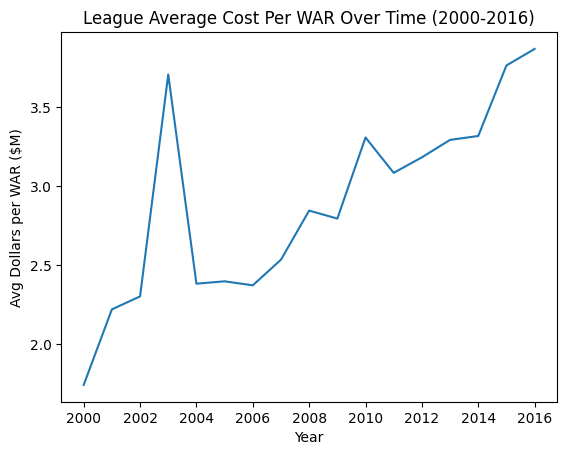

In [14]:
yearly = clean.groupby("yearID", as_index=False).agg(
    avg_dollars_per_war=("Dollars_per_WAR", "mean"),
    median_dollars_per_war=("Dollars_per_WAR", "median"),
    avg_payroll=("payroll", "mean"),
    avg_war=("Total_WAR", "mean"),
    avg_wins=("W", "mean")
)

plt.figure()
plt.plot(yearly["yearID"], yearly["avg_dollars_per_war"]/1e6)
plt.xlabel("Year")
plt.ylabel("Avg Dollars per WAR ($M)")
plt.title("League Average Cost Per WAR Over Time (2000-2016)")
plt.show

## Team-level Effciency

In [16]:
team_summary = clean.groupby(["teamID"], as_index=False).agg(
    seasons=("yearID", "count"),
    avg_wins=("W", "mean"),
    avg_payroll=("payroll", "mean"),
    avg_war=("Total_WAR", "mean"),
    avg_cost_per_war=("Dollars_per_WAR", "mean"),
    median_cost_per_war=("Dollars_per_WAR", "median"),
)

team_summary=team_summary[team_summary["seasons"] >= 10].copy() # stability filter
team_summary.sort_values("median_cost_per_war").head(10)

,teamID,seasons,avg_wins,avg_payroll,avg_war,avg_cost_per_war,median_cost_per_war
11,FLO,12,80.250000,3.895117e+07,30.677670,1.278109e+06,1.234043e+06
22,OAK,17,85.882353,5.870295e+07,38.629942,1.698472e+06,1.418048e+06
29,TBA,17,75.764706,4.844585e+07,31.913883,1.703114e+06,1.423456e+06
18,MIN,17,80.235294,6.924926e+07,32.385957,2.713499e+06,1.773742e+06
8,CLE,17,81.470588,6.817136e+07,35.650339,2.091679e+06,1.916171e+06
25,SDN,17,76.529412,6.143429e+07,27.729597,2.430784e+06,2.066415e+06
31,TOR,17,81.352941,8.029162e+07,36.808295,2.212721e+06,2.086845e+06
24,PIT,17,73.352941,5.451046e+07,23.587985,3.145192e+06,2.094217e+06
2,ATL,17,86.823529,8.875199e+07,38.245105,2.460214e+06,2.152424e+06
1,ARI,17,78.705882,7.401161e+07,30.343725,3.028712e+06,2.319167e+06


Best Value

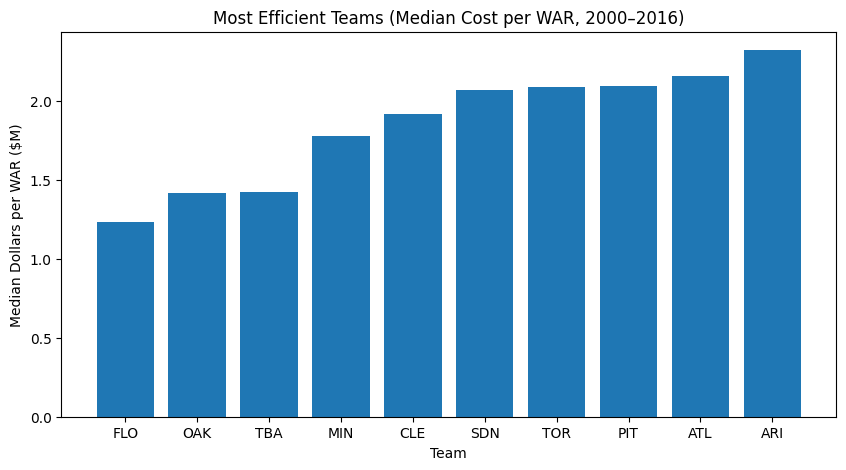

In [17]:
top10 = team_summary.sort_values("median_cost_per_war").head(10)

plt.figure(figsize=(10, 5))
plt.bar(top10["teamID"], top10["median_cost_per_war"]/1e6)
plt.xlabel("Team")
plt.ylabel("Median Dollars per WAR ($M)")
plt.title("Most Efficient Teams (Median Cost per WAR, 2000–2016)")
plt.show()


Worst Value

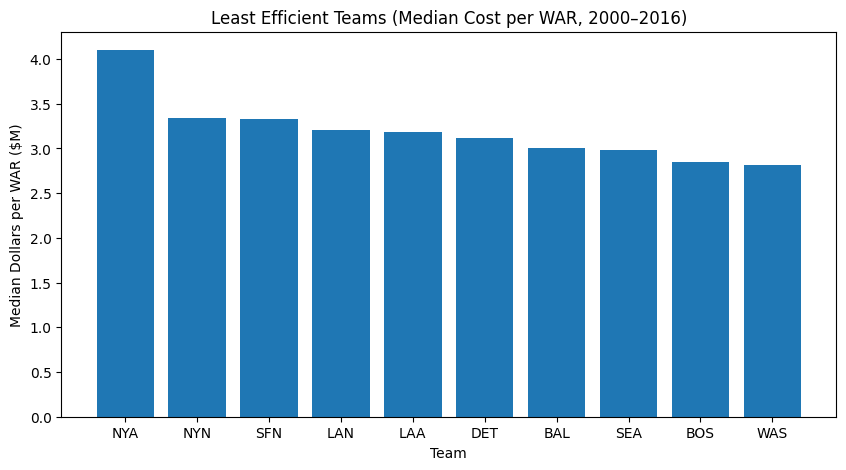

In [18]:
bottom10 = team_summary.sort_values("median_cost_per_war", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(bottom10["teamID"], bottom10["median_cost_per_war"]/1e6)
plt.xlabel("Team")
plt.ylabel("Median Dollars per WAR ($M)")
plt.title("Least Efficient Teams (Median Cost per WAR, 2000–2016)")
plt.show()


Overperformers vs Expectation

In [19]:
df["Expected_Wins_simple"] = 48 + 3 * df["Total_WAR"]
df["Wins_Above_Expected"] = df["W"] - df["Expected_Wins_simple"]

df.sort_values("Wins_Above_Expected", ascending=False).head(10)[
    ["yearID","teamID","W","Total_WAR","Wins_Above_Expected","payroll"]
]


,yearID,teamID,W,Total_WAR,Wins_Above_Expected,payroll
321,2010,PIT,57,2.245000,2.265000,34943000
100,2003,DET,43,1.088333,-8.265000,49168000
162,2005,KCA,56,5.548333,-8.645000,36881000
400,2013,HOU,51,4.676667,-11.030000,17890700
121,2004,ARI,51,6.126667,-15.380000,69780750
346,2011,MIN,63,10.683333,-17.050000,112737000
47,2001,MON,68,12.790000,-18.370000,35159500
70,2002,DET,55,8.472298,-18.416894,55048000
52,2001,PIT,62,10.933333,-18.800000,57760833
127,2004,CIN,76,16.601667,-21.805000,46615250


## Payroll vs Wins

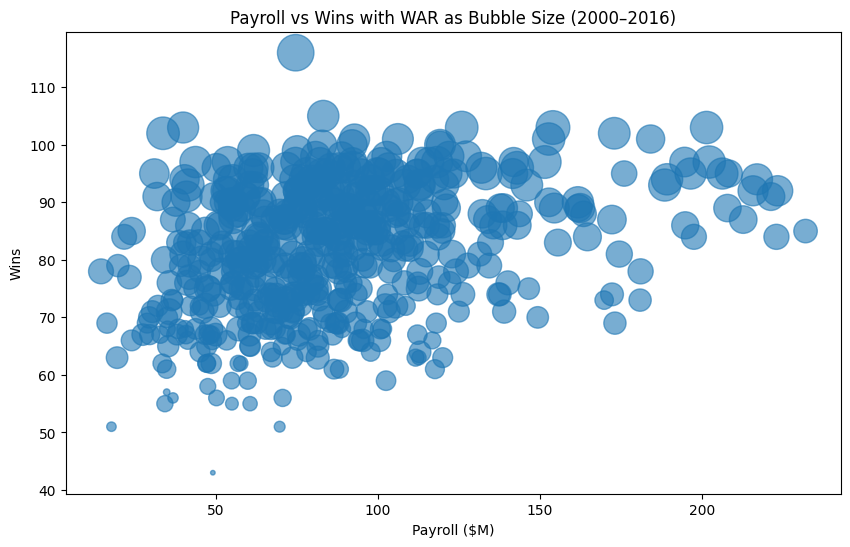

In [21]:
plt.figure(figsize=(10,6))

plt.scatter(
    df["payroll"]/1e6,
    df["W"],
    s=df["Total_WAR"]*10, #Scale for visibility
    alpha = 0.6
)

plt.xlabel("Payroll ($M)")
plt.ylabel("Wins")
plt.title("Payroll vs Wins with WAR as Bubble Size (2000–2016)")

plt.show()

This visualization highlights WAR as the key mediating variable between payroll and wins.
Teams with similar payrolls often produce vastly different win totals depending on how
effectively spending translates into on-field value. Large bubbles at lower payroll levels
suggest efficient roster construction, while smaller bubbles among high-payroll teams
indicate diminishing returns on spending.
